# Jupyter notebook: Latency comparison across scenarios
#
# This notebook loads the four scenario CSVs, preprocesses timestamps/latencies,
# computes summary statistics and draws comparison charts with the three event
# types color-coded: newMachine, machineFailure, storageAlert.


In [1]:
# Section 1: Imports and plotting config
import sys
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Helper for safe pip install in notebook if seaborn/matplotlib not available
try:
    import seaborn as sns  # noqa: F401
except Exception:
    print('Installing seaborn...')
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
    import seaborn as sns


In [2]:
# Section 2: Define file paths & scenario mapping and load CSVs
from pprint import pprint

base = Path('.')  # workspace root
results_dir = base / 'src' / 'dockerProject' / 'results'

# Requested order: 5m_1k, 5m_2k, 5m_3k, 5m_4k, 3m_1k, 3m_2k
files_order = [
    ('5m1k.csv', '5m_1k'),
    ('5m2k.csv', '5m_2k'),
    ('5m3k.csv', '5m_3k'),
    ('5m4k.csv', '5m_4k'),
    ('3m1k.csv', '3m_1k'),
    ('3m2k.csv', '3m_2k'),
]

# Read CSVs
dfs = {}
for fname, label in files_order:
    path = results_dir / fname
    if not path.exists():
        print(f"WARNING: file not found: {path}")
        dfs[label] = pd.DataFrame()
        continue
    df = pd.read_csv(path, dtype={"metadata": str})
    df['__source_filename'] = fname
    df['scenario'] = label
    dfs[label] = df

print('Loaded scenarios:')
for k, df in dfs.items():
    print(k, 'rows =', len(df))


Loaded scenarios:
5m_1k rows = 79
5m_2k rows = 93
5m_3k rows = 136
5m_4k rows = 109
3m_1k rows = 59
3m_2k rows = 85


In [3]:
# Section 3: Preprocess timestamps, latencies and parse metadata
import math

# helper to coerce numeric, keep NaN when missing
def to_int_safe(x):
    try:
        if pd.isna(x):
            return np.nan
        return int(x)
    except Exception:
        try:
            return int(float(x))
        except Exception:
            return np.nan

processed = []
for label, df in dfs.items():
    if df.empty:
        continue
    d = df.copy()

    # --- Map possible alternate column names from new CSV format ---
    if 'id' in d.columns and 'event_id' not in d.columns:
        d['event_id'] = d['id']
    if 'type' in d.columns and 'event_type' not in d.columns:
        d['event_type'] = d['type']

    # numeric coercion
    for col in ['trigger_ts', 'reaction_ts', 'solved_ts', 'resolution_time_ms', 'total_response_time_ms']:
        if col in d.columns:
            d[col] = pd.to_numeric(d[col], errors='coerce')
        else:
            d[col] = np.nan

    # timestamps -> datetimes (ms)
    d['trigger_dt'] = pd.to_datetime(d['trigger_ts'], unit='ms', errors='coerce')
    d['reaction_dt'] = pd.to_datetime(d['reaction_ts'], unit='ms', errors='coerce')
    d['solved_dt'] = pd.to_datetime(d['solved_ts'], unit='ms', errors='coerce')

    # derived delays
    d['reaction_delay_ms'] = d['reaction_ts'] - d['trigger_ts']
    d['solved_delay_ms'] = d['solved_ts'] - d['trigger_ts']

    # parse metadata JSON safely (guard if missing)
    def parse_meta(s):
        if pd.isna(s):
            return {}
        try:
            return json.loads(s)
        except Exception:
            # sometimes single quotes or escaping; try replace
            try:
                return json.loads(s.replace("'", '"'))
            except Exception:
                return {}

    if 'metadata' in d.columns:
        meta_parsed = d['metadata'].fillna('{}').map(parse_meta)
    else:
        meta_parsed = pd.Series([{}] * len(d), index=d.index)

    # expand a few common fields
    d['meta_first_state'] = meta_parsed.map(lambda m: m.get('first_state') if isinstance(m, dict) else None)
    d['meta_swap_target_machine'] = meta_parsed.map(lambda m: m.get('swap_target_machine') if isinstance(m, dict) else None)
    d['meta_problemCategory'] = meta_parsed.map(lambda m: m.get('problemCategory') if isinstance(m, dict) else None)

    # ensure event_type is str (fallback to 'unknown')
    if 'event_type' in d.columns:
        d['event_type'] = d['event_type'].astype(str)
    else:
        d['event_type'] = 'unknown'

    processed.append(d)

# concatenate
if processed:
    master = pd.concat(processed, ignore_index=True, sort=False)
else:
    master = pd.DataFrame()

print('Master rows:', len(master))

# quick sanity: unique event types
print('Event types:', master['event_type'].unique() if 'event_type' in master.columns else [])


Master rows: 561
Event types: ['newMachine' 'machineFailure' 'storageAlert']


In [4]:
# Section 4: Aggregates and comparison table (focus on MEAN, include seconds)
# Compute summary statistics per scenario and event_type
if master.empty:
    print('No data to summarize')
else:
    # Ensure we have an event identifier for counts
    if 'event_id' not in master.columns:
        master['event_id'] = master.index.astype(str)

    # Ensure numeric columns exist (coerce when present)
    numeric_cols = ['total_response_time_ms', 'resolution_time_ms', 'scheduler_latency', 'machine_latency', 'trigger_ts', 'reaction_ts', 'solved_ts']
    for col in numeric_cols:
        if col in master.columns:
            master[col] = pd.to_numeric(master[col], errors='coerce')
        else:
            master[col] = np.nan

    # Try to derive missing metrics when possible
    # total_response_time_ms: prefer solved_ts - trigger_ts, else sum latencies
    if master['total_response_time_ms'].isna().all():
        have_ts = master['solved_ts'].notna() & master['trigger_ts'].notna()
        if have_ts.any():
            master.loc[have_ts, 'total_response_time_ms'] = master.loc[have_ts, 'solved_ts'] - master.loc[have_ts, 'trigger_ts']
        elif master[['scheduler_latency', 'machine_latency']].notna().any(axis=1).any():
            master['total_response_time_ms'] = master['scheduler_latency'].fillna(0) + master['machine_latency'].fillna(0)

    # resolution_time_ms: prefer solved_ts - reaction_ts, else scheduler_latency
    if master['resolution_time_ms'].isna().all():
        have_ts = master['solved_ts'].notna() & master['reaction_ts'].notna()
        if have_ts.any():
            master.loc[have_ts, 'resolution_time_ms'] = master.loc[have_ts, 'solved_ts'] - master.loc[have_ts, 'reaction_ts']
        elif master['scheduler_latency'].notna().any():
            master['resolution_time_ms'] = master['scheduler_latency']

    # Now aggregate safely (columns exist, may contain NaN)
    agg = master.groupby(['scenario', 'event_type']).agg(
        count=('event_id', 'count'),
        mean_total_response_ms=('total_response_time_ms', 'mean'),
        median_total_response_ms=('total_response_time_ms', 'median'),
        std_total_response_ms=('total_response_time_ms', 'std'),
        q25_total_response_ms=('total_response_time_ms', lambda x: np.nanpercentile(x.dropna(), 25) if len(x.dropna()) > 0 else np.nan),
        q75_total_response_ms=('total_response_time_ms', lambda x: np.nanpercentile(x.dropna(), 75) if len(x.dropna()) > 0 else np.nan),
        mean_resolution_ms=('resolution_time_ms', 'mean'),
        median_resolution_ms=('resolution_time_ms', 'median')
    ).reset_index()

    # Add mean values in seconds (divide ms by 1000)
    agg['mean_total_response_s'] = agg['mean_total_response_ms'] / 1000.0
    agg['mean_resolution_s'] = agg['mean_resolution_ms'] / 1000.0

    # pivoted comparison table (MEAN in seconds)
    pivot_mean_s = agg.pivot(index='event_type', columns='scenario', values='mean_total_response_s')

    # reorder columns to the requested scenario order but only keep those present
    requested_order = ['5m_1k', '5m_2k', '5m_3k', '5m_4k', '3m_1k', '3m_2k']
    present_cols = [c for c in requested_order if c in pivot_mean_s.columns]
    if present_cols:
        pivot_mean_s = pivot_mean_s[present_cols]

    print('\nMean total_response_time (seconds) by event_type and scenario (requested order):')
    display(pivot_mean_s)

    # Save summary CSVs (agg in ms + mean table in seconds)
    out_dir = Path('analysis_outputs')
    out_dir.mkdir(exist_ok=True)
    agg.to_csv(out_dir / 'summary_by_scenario_eventtype.csv', index=False)
    pivot_mean_s.to_csv(out_dir / 'mean_table_seconds.csv')
    print('\nSaved summaries to', out_dir, ' (including mean_table_seconds.csv)')



Mean total_response_time (seconds) by event_type and scenario (requested order):


scenario,5m_1k,5m_2k,5m_3k,5m_4k,3m_1k,3m_2k
event_type,,,,,,
machineFailure,4.424400,5.676091,6.497000,7.839538,4.294000,11.348400
newMachine,9.500683,10.064114,9.305183,9.570892,8.804978,8.959028
storageAlert,5.780214,4.366000,5.996667,4.062333,3.126571,3.006500



Saved summaries to analysis_outputs  (including mean_table_seconds.csv)


/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_75530/2756276374.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_75530/2756276374.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_75530/2756276374.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/kf/fqsk3qbn3h9ccbj4wkfz9g200000gn/T/ipykernel_75530/2756276374.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

Saved boxplots to analysis_outputs/boxplots_total_response_time_ms.png
Saved percentage grouped bar chart to analysis_outputs/percentage_by_eventtype.png
Saved counts grouped bar chart to analysis_outputs/counts_by_eventtype.png


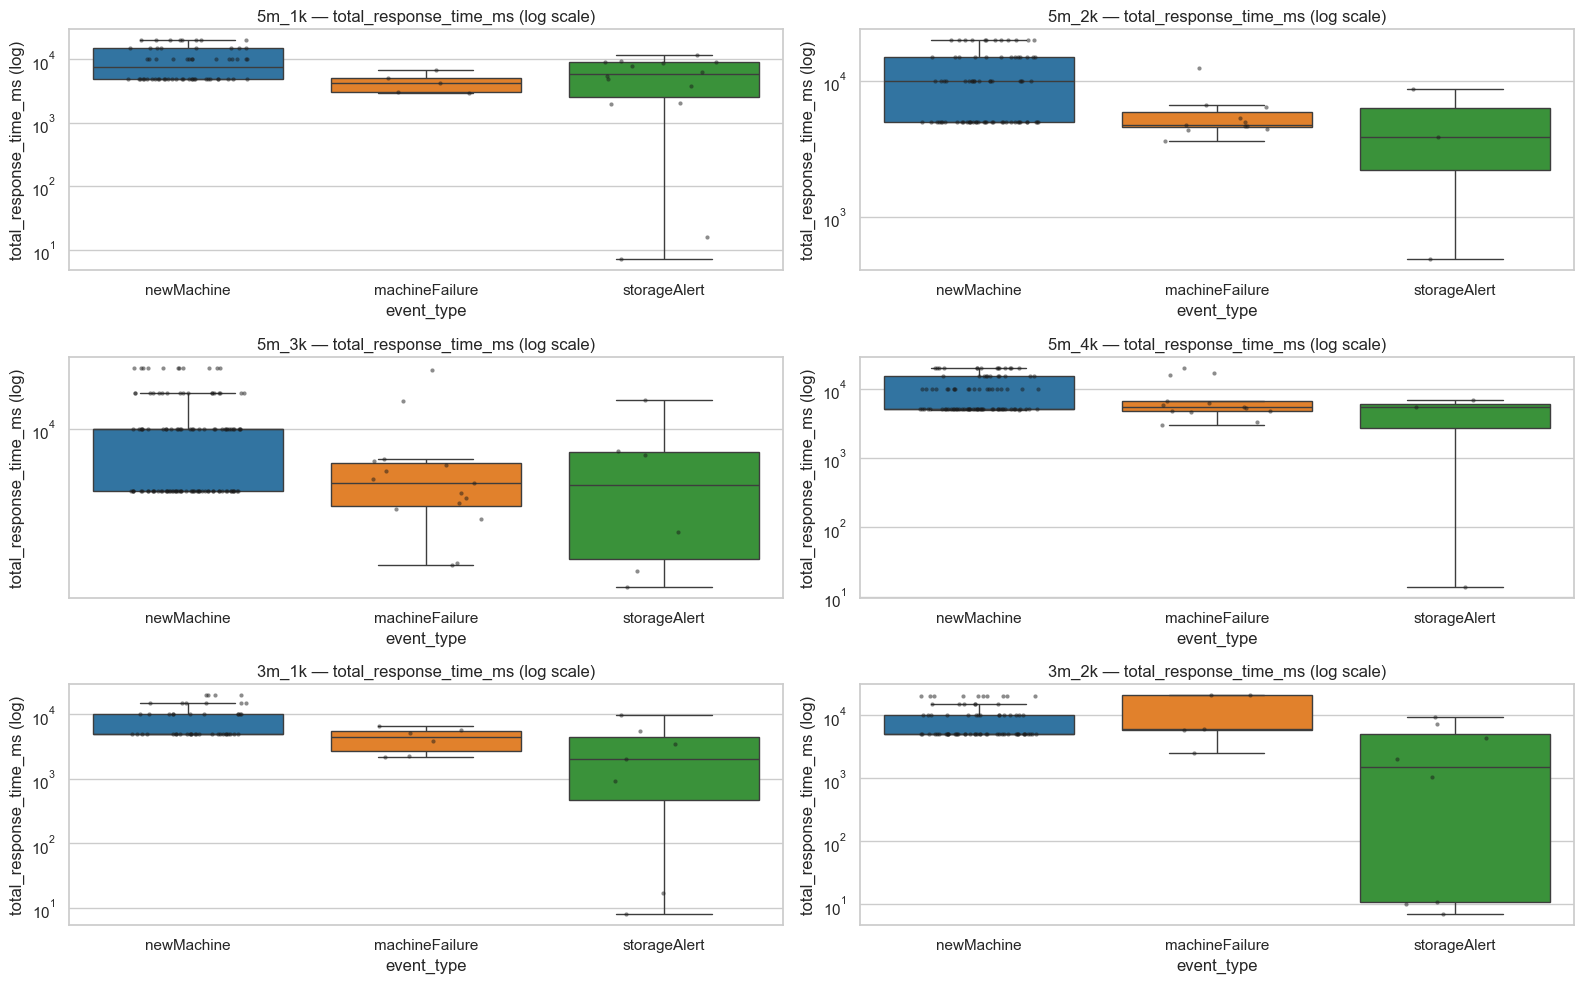

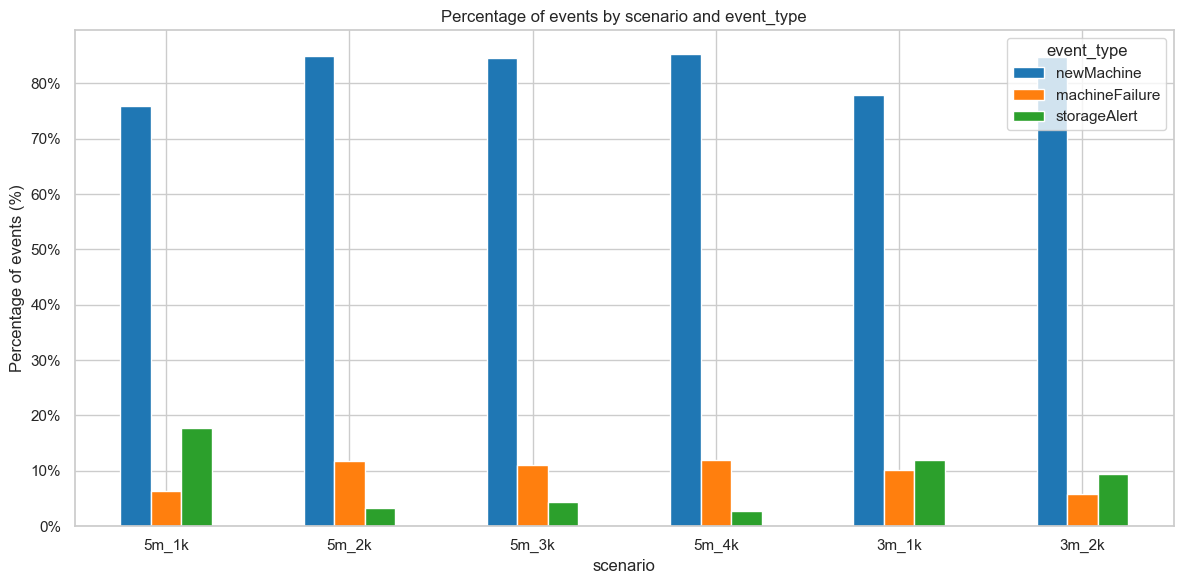

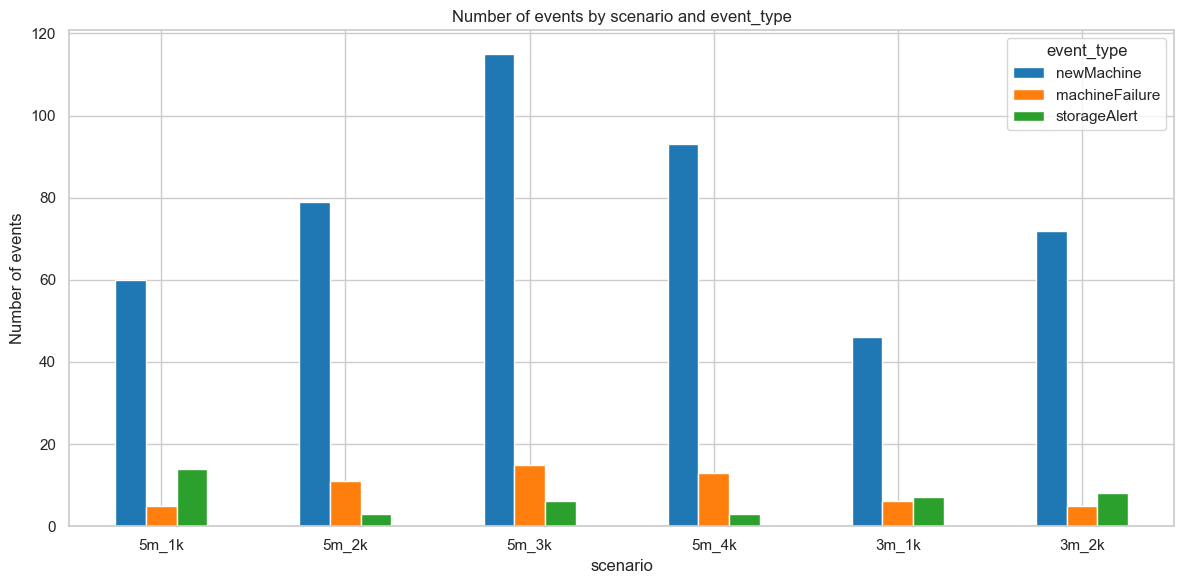

In [5]:
# Section 5: Plots — boxplots (per-scenario) and a grouped bar chart showing PERCENTAGE of events per event_type
import matplotlib.ticker as ticker

if master.empty:
    print('No data to plot')
else:
    event_order = ['newMachine', 'machineFailure', 'storageAlert']
    # consistent color mapping
    color_map = {
        'newMachine': '#1f77b4',
        'machineFailure': '#ff7f0e',
        'storageAlert': '#2ca02c'
    }

    scenarios = ['5m_1k','5m_2k','5m_3k','5m_4k','3m_1k','3m_2k']

    # --- Per-scenario boxplots (log scale) ---
    fig, axes = plt.subplots(3, 2, figsize=(16, 10))
    axes = axes.flatten()
    for ax, scen in zip(axes, scenarios):
        sub = master[master['scenario'] == scen]
        if sub.empty:
            ax.text(0.5, 0.5, f'No data for {scen}', ha='center')
            ax.set_xticks([])
            continue
        # boxplot — total_response_time_ms by event_type
        sns.boxplot(
            data=sub,
            x='event_type', y='total_response_time_ms',
            order=event_order,
            palette=[color_map.get(e, '#333333') for e in event_order],
            ax=ax,
            showfliers=False
        )
        # overlay some points (jittered)
        sns.stripplot(
            data=sub, x='event_type', y='total_response_time_ms',
            order=event_order, color='k', size=3, jitter=0.25, alpha=0.5, ax=ax
        )
        ax.set_yscale('log')
        ax.set_title(f'{scen} — total_response_time_ms (log scale)')
        ax.set_xlabel('event_type')
        ax.set_ylabel('total_response_time_ms (log)')

    plt.tight_layout()
    out_dir = Path('analysis_outputs')
    out_dir.mkdir(exist_ok=True)
    plt.savefig(out_dir / 'boxplots_total_response_time_ms.png', dpi=150)
    print('Saved boxplots to', out_dir / 'boxplots_total_response_time_ms.png')

    # --- Grouped bar chart: percentage of each event type per scenario ---
    # counts per scenario x event_type
    counts = master.groupby(['scenario','event_type']).size().unstack(fill_value=0).reindex(scenarios).fillna(0)
    # ensure column order
    counts = counts[event_order]

    # save raw counts
    counts.to_csv(out_dir / 'counts_by_scenario_eventtype.csv')

    # compute percentage per scenario (row-wise)
    totals = counts.sum(axis=1).replace(0, np.nan)
    percent = counts.div(totals, axis=0).fillna(0) * 100.0
    percent.to_csv(out_dir / 'percent_by_scenario_eventtype.csv')

    # plot grouped bars: x=scenario, bars=event types (percentage)
    ax = percent.plot(kind='bar', figsize=(12,6), color=[color_map[e] for e in event_order])
    ax.set_ylabel('Percentage of events (%)')
    ax.set_title('Percentage of events by scenario and event_type')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
    plt.xticks(rotation=0)
    plt.legend(title='event_type')
    plt.tight_layout()
    plt.savefig(out_dir / 'percentage_by_eventtype.png', dpi=150)
    print('Saved percentage grouped bar chart to', out_dir / 'percentage_by_eventtype.png')

    # Also provide a raw-number grouped bar plot (optional) for comparison
    ax2 = counts.plot(kind='bar', figsize=(12,6), color=[color_map[e] for e in event_order])
    ax2.set_ylabel('Number of events')
    ax2.set_title('Number of events by scenario and event_type')
    plt.xticks(rotation=0)
    plt.legend(title='event_type')
    plt.tight_layout()
    plt.savefig(out_dir / 'counts_by_eventtype.png', dpi=150)
    print('Saved counts grouped bar chart to', out_dir / 'counts_by_eventtype.png')


# Section 6: Notes & how to run

1. Open this notebook in Jupyter/VS Code and run all cells in order.
2. The notebook expects the CSVs in `src/dockerProject/results/` (relative to repo root).
3. Output files (summaries + PNGs) are saved to `analysis_outputs/`.

If seaborn is not available, the notebook will try to install it automatically. If you prefer to install packages manually, run:

```bash
python3 -m pip install seaborn matplotlib pandas
```

That's it — run the cells and you should see the 2x2 boxplots and grouped bar chart comparing latencies across scenarios, with event types color-coded.


In [6]:
# LATENCY ANALYSIS SUMMARY
# Produces a human-readable text summary per event_type and global stats
out_dir = Path('analysis_outputs')
out_dir.mkdir(exist_ok=True)

if 'master' not in globals() or master.empty:
    print('No master dataframe available — run previous cells to load data')
else:
    df = master.copy()

    # ensure numeric latency columns exist
    for col in ['scheduler_latency', 'machine_latency', 'total_response_time_ms']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            df[col] = np.nan

    # derive total_response_time_ms when missing per-row
    missing_total = df['total_response_time_ms'].isna()
    if missing_total.any():
        # if solved_ts and trigger_ts present, use their difference
        if 'solved_ts' in df.columns and 'trigger_ts' in df.columns:
            have_ts = df['solved_ts'].notna() & df['trigger_ts'].notna()
            df.loc[have_ts & missing_total, 'total_response_time_ms'] = (
                pd.to_numeric(df.loc[have_ts & missing_total, 'solved_ts'], errors='coerce')
                - pd.to_numeric(df.loc[have_ts & missing_total, 'trigger_ts'], errors='coerce')
            )
        # fallback to sum of scheduler + machine latencies
        still_missing = df['total_response_time_ms'].isna()
        if still_missing.any() and ('scheduler_latency' in df.columns and 'machine_latency' in df.columns):
            df.loc[still_missing, 'total_response_time_ms'] = (
                df.loc[still_missing, 'scheduler_latency'].fillna(0)
                + df.loc[still_missing, 'machine_latency'].fillna(0)
            )

    # helper to format ms and s
    def fmt_ms_s(x):
        if pd.isna(x):
            return 'N/A'
        return f"{x:.2f} ms ({x/1000.0:.3f} s)"

    lines = []
    lines.append('='*79)
    lines.append('LATENCY ANALYSIS SUMMARY')
    lines.append('='*79)
    lines.append('')

    # Per event type
    for etype, group in df.groupby('event_type'):
        total_events = len(group)
        avg_scheduler = group['scheduler_latency'].dropna().mean()
        avg_machine = group['machine_latency'].dropna().mean()
        avg_total = group['total_response_time_ms'].dropna().mean()

        lines.append(f"Event Type: {etype}")
        lines.append('-'*80)
        lines.append(f"  Total Events: {total_events}")
        lines.append(f"  Average Scheduler Latency: {fmt_ms_s(avg_scheduler)}")
        lines.append(f"  Average Machine Latency: {fmt_ms_s(avg_machine)}")
        lines.append(f"  Average Total Latency: {fmt_ms_s(avg_total)}")
        lines.append('')

    # Global stats
    total_all = len(df)
    avg_scheduler_all = df['scheduler_latency'].dropna().mean()
    avg_machine_all = df['machine_latency'].dropna().mean()
    avg_total_all = df['total_response_time_ms'].dropna().mean()

    lines.append('='*79)
    lines.append('GLOBAL STATISTICS')
    lines.append('='*79)
    lines.append(f"  Total Events (All Types): {total_all}")
    lines.append(f"  Average Scheduler Latency: {fmt_ms_s(avg_scheduler_all)}")
    lines.append(f"  Average Machine Latency: {fmt_ms_s(avg_machine_all)}")
    lines.append(f"  Average Total Latency: {fmt_ms_s(avg_total_all)}")
    lines.append('='*79)

    report = '\n'.join(lines)
    print(report)

    # save to file
    (out_dir / 'latency_summary.txt').write_text(report)
    print('\nSaved latency summary to', out_dir / 'latency_summary.txt')


LATENCY ANALYSIS SUMMARY

Event Type: machineFailure
--------------------------------------------------------------------------------
  Total Events: 55
  Average Scheduler Latency: 4654.98 ms (4.655 s)
  Average Machine Latency: 2007.45 ms (2.007 s)
  Average Total Latency: 6662.44 ms (6.662 s)

Event Type: newMachine
--------------------------------------------------------------------------------
  Total Events: 465
  Average Scheduler Latency: 5626.61 ms (5.627 s)
  Average Machine Latency: 3782.79 ms (3.783 s)
  Average Total Latency: 9409.41 ms (9.409 s)

Event Type: storageAlert
--------------------------------------------------------------------------------
  Total Events: 41
  Average Scheduler Latency: 3655.93 ms (3.656 s)
  Average Machine Latency: 932.51 ms (0.933 s)
  Average Total Latency: 4588.44 ms (4.588 s)

GLOBAL STATISTICS
  Total Events (All Types): 561
  Average Scheduler Latency: 5387.33 ms (5.387 s)
  Average Machine Latency: 3400.43 ms (3.400 s)
  Average Total 